## do-mpc model and solver setup

In [311]:
import do_mpc
import numpy as np

model_type = 'continuous' 
model = do_mpc.model.Model(model_type)

#x_1' = x_2 = x'
#x_2' = (-k/m)x_1 - (c/m)x_2 + (1/m)u = x''
x_1 = model.set_variable(var_type='_x', var_name='x_1', shape=(1,1))
x_2 = model.set_variable(var_type='_x', var_name='x_2', shape=(1,1))

#defining the control input
u = model.set_variable(var_type='_u', var_name='u')

# Parameters
m = 20
k = 2
c = 4

## Set the right hand sides of the ODEs and set MPC parameters

In [312]:
#right hand side of the ODE
model.set_rhs('x_1', x_2)
model.set_rhs('x_2', (-k/m)*x_1 - (c/m)*x_2 + (1/m)*u)

# Define the initial conditions
model.x0 = np.array([0, 0])


# Define the objective function
model.setup()
mpc = do_mpc.controller.MPC(model)

setup_mpc = {
    'n_horizon': 20,
    't_step': 0.1,
    'n_robust': 0,
    'store_full_solution': True,
}
mpc.set_param(**setup_mpc)

#initial statel
x0 = np.array([0, 0]).reshape(-1,1)
#desired state
x1_desired = 1
x2_desired = 0

mterm = (x_1-x1_desired)**2 + (x_2-x2_desired)**2
lterm = (x_1-x1_desired)**2 + (x_2-x2_desired)**2

mpc.set_objective(mterm=mterm, lterm=lterm)
mpc.set_rterm(
    u=0.01,
)

mpc.setup()
mpc.x0 = x0
mpc.set_initial_guess()



## Set simulation parameters

In [313]:
simulator = do_mpc.simulator.Simulator(model)
simulator.set_param(t_step = 0.1)
simulator.setup()
simulator.x0 = x0

## Running simulation with 0 control

In [314]:
import matplotlib.pyplot as plt
import matplotlib as mpl
# Customizing Matplotlib:
mpl.rcParams['font.size'] = 18
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.grid'] = True
mpc_graphics = do_mpc.graphics.Graphics(mpc.data)
sim_graphics = do_mpc.graphics.Graphics(simulator.data)

In [315]:
%%capture
# We just want to create the plot and not show it right now. This "inline magic" supresses the output.
fig, ax = plt.subplots(2, sharex=True, figsize=(10,14))
fig.align_ylabels()

In [316]:

for g in [sim_graphics, mpc_graphics]:
    # Plot the angle positions (phi_1, phi_2, phi_2) on the first axis:
    g.add_line(var_type='_x', var_name='x_1', axis=ax[0])
    g.add_line(var_type='_x', var_name='x_2', axis=ax[0])

    # Plot the set motor positions (phi_m_1_set, phi_m_2_set) on the second axis:
    g.add_line(var_type='_u', var_name='u', axis=ax[1])


ax[0].set_ylabel('cart position [m]')
ax[1].set_ylabel('control input [F]')
ax[1].set_xlabel('time [s]')

u0 = np.ones((1,1))
for i in range(200):
    simulator.make_step(u0)

In [317]:
u0 = np.ones((1,1))
for i in range(200):
    simulator.make_step(u0)

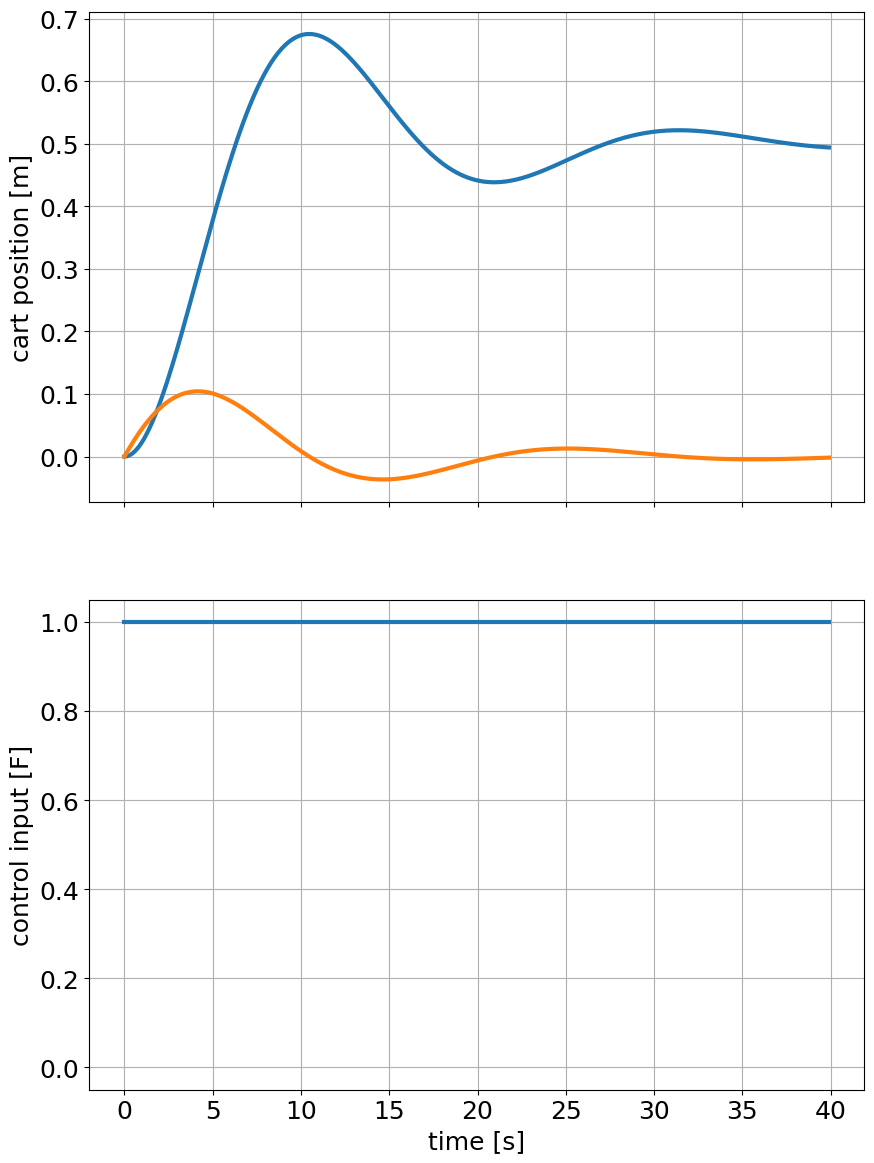

In [318]:
sim_graphics.plot_results()
# Reset the limits on all axes in graphic to show the data.
sim_graphics.reset_axes();fig

# Running the control loop

In [319]:
simulator.reset_history()
simulator.x0 = x0
mpc.reset_history()

In [320]:
%%capture 

# Run the simulation and the controller for 20 steps:
for i in range(200):
    u0 = mpc.make_step(x0)
    x0 = simulator.make_step(u0)



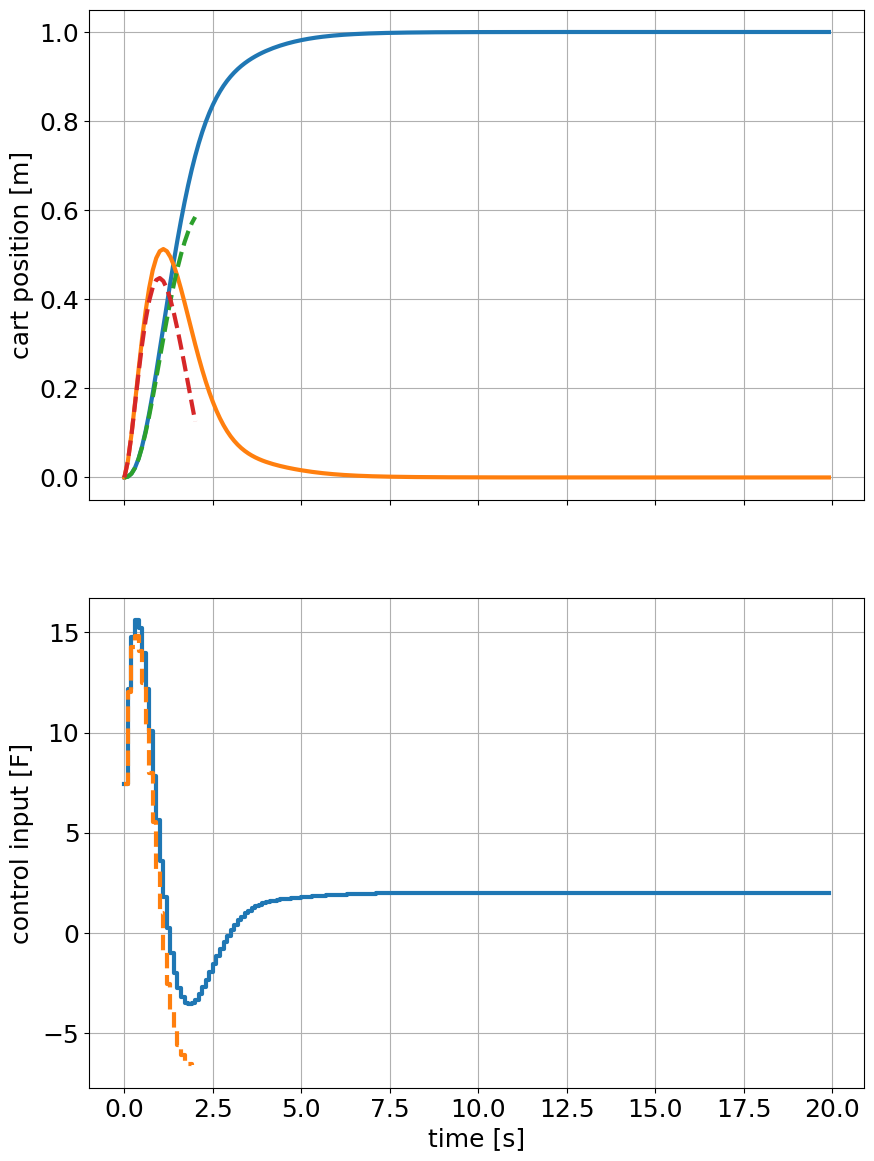

In [321]:
# Plot predictions from t=0
mpc_graphics.plot_predictions(t_ind=0)
# Plot results until current time
sim_graphics.plot_results()
sim_graphics.reset_axes()
fig